# Updates

In [10]:
!pip install -U transformers
!pip install -U accelerate

After updating packages, restart the session and then start your notebook from imports.

# Imports

In [11]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load model

In [12]:
MODEL_ARGS = {
    'Name': 'microsoft/Phi-3-mini-128k-instruct',
    'DType': torch.bfloat16
}

In [13]:
def load_model(model_args):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = AutoModelForCausalLM.from_pretrained(
        model_args['Name'],
        trust_remote_code=True,
        torch_dtype=model_args['DType'],
        low_cpu_mem_usage=True,
        device_map={"": device},
    )
    tokenizer = AutoTokenizer.from_pretrained(
        model_args['Name'],
        trust_remote_code=True,
    )

    return model, tokenizer

In [14]:
model, tokenizer = load_model(MODEL_ARGS)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Reading the Data

In [18]:
import json
import torcharrow as ta
def read_jsonl(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            data.append(json.loads(line))
    return data

def process_data(data):
    reviews = []
    labels = []
    embeddings = []

    for item in data:
        reviews.append(item["text"])
        labels.append(item["label"])
        embeddings.append(item['embedding'])

    return reviews, labels, embeddings

def create_ta_dataframe(reviews, labels, embeddings):
    df = ta.dataframe({
        'review': reviews,
        'label': labels,
        'embedding': embeddings
    })
    return df

In [19]:
train_df = create_ta_dataframe(
    *process_data(
        read_jsonl("imdb/train_imdb.jsonl")
    )
)

In [20]:
train_df.describe()

  index  metric         label
-------  --------  ----------
      0  count     150
      1  mean        0.553333
      2  std         0.498813
      3  min         0
      4  25%         0
      5  50%         1
      6  75%         1
      7  max         1
dtype: Struct([Field('metric', string), Field('label', float32)]), count: 8, null_count: 0

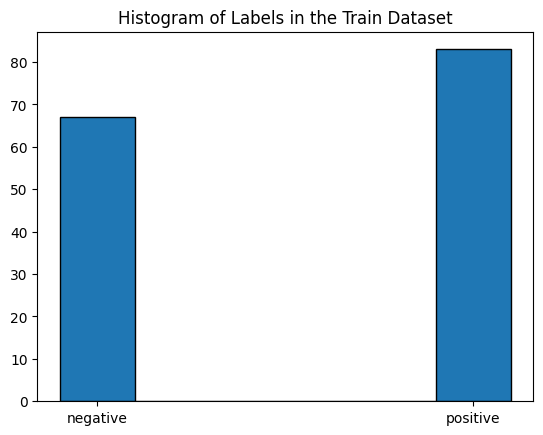

In [22]:
import matplotlib.pyplot as plt

plt.hist(train_df['label'], bins=[-0.1, 0.1, 0.9, 1.1], edgecolor="black")
plt.title("Histogram of Labels in the Train Dataset")
plt.xticks([0, 1], labels=['negative', 'positive'])
plt.show()